


**Image Search By an Artistic Style**

This notebook demonstrates how images can be searched by style. One typical business case is an eCommerce webiste that allows to search a poster based on the example uploaded by the user. A user would usually expect to get results that are similar in terms of artisitc style. A real search system would typically mix style similarity with other similarity score such as image subject or category (landscape, still life, etc.) that can also be obtained using deep neural networks.

The implementation is based on a TensorFlow tutorial on Neural Style Transfer which is in turn based on a seminal paper A Neural Algorithm of Artistic Style by Gatys et al.



In [ ]:
# importing the required libraries
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import ntpath
import cv2
from sklearn.metrics.pairwise import cosine_similarity
import scipy as sc
import pandas as pd
import numpy as np

In [ ]:
# to connect with google drive
from google.colab import drive

# this will prompt for authorization
drive.mount('/content/drive')

Mounted at /content/drive


Found [550] images


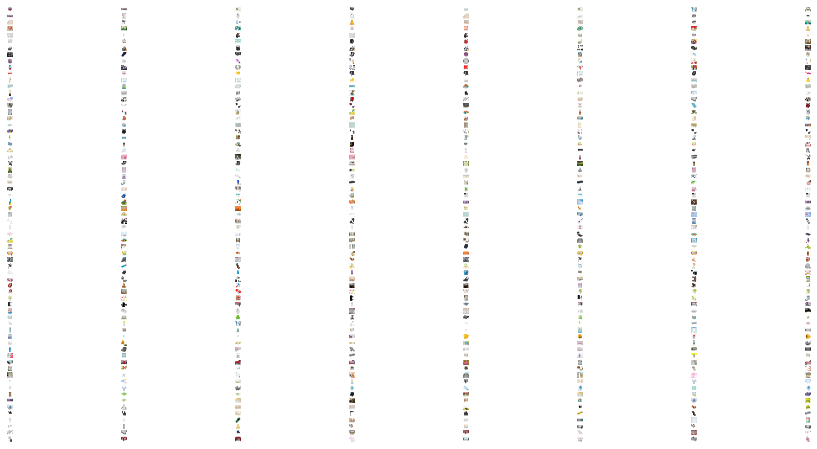

In [ ]:
# to load all the images from the dataset to be used for similarity search 
image_paths = glob.glob('/content/drive/My Drive/ADM-A3/Dataset/*.jpg')
print(f'Found [{len(image_paths)}] images')

images = {}
for image_path in image_paths:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           
    image = cv2.merge([r,g,b])         
    image = cv2.resize(image, (200, 200))
    images[ntpath.basename(image_path)] = image      

n_col = 8
n_row = int(len(images)/n_col)
f, ax = plt.subplots(n_row, n_col, figsize=(16, 8))
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].imshow(list(images.values())[n_col*i + j])
        ax[i, j].set_axis_off()


**Pre-processing and modelling**

In [ ]:
# to load the images in the Tensorflow and Keras model
def load_image(image):
  image = plt.imread(image)
  img = tf.image.convert_image_dtype(image, tf.float32)
  img = tf.image.resize(img, [400, 400])
  img = img[tf.newaxis, :] # shape -> (batch_size, h, w, d)
  return img

# content layers describe the image subject
content_layers = ['block5_conv2'] 


# style layers describe the image style
# we exclude the upper level layes to focus on small-size style details
style_layers = [ 
        'block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        #'block4_conv1', 
        #'block5_conv1'
    ] 

def selected_layers_model(layer_names, baseline_model):
  outputs = [baseline_model.get_layer(name).output for name in layer_names]
  model = Model([vgg.input], outputs)
  return model

# style embedding is computed as concatenation of gram matrices of the style layers
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

class StyleModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleModel, self).__init__()
    self.vgg =  selected_layers_model(style_layers + content_layers, vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    # scale back the pixel values
    inputs = inputs*255.0
    # preprocess them with respect to VGG19 stats
    preprocessed_input = preprocess_input(inputs)
    # pass through the reduced network
    outputs = self.vgg(preprocessed_input)
    # segregate the style and content representations
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # calculate the gram matrix for each layer
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    # assign the content representation and gram matrix in
    # a layer by layer fashion in dicts
    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

def image_to_style(image_tensor):
    extractor = StyleModel(style_layers, content_layers)
    return extractor(image_tensor)['style']

def style_to_vec(style):
    # concatenate gram matrics in a flat vector
    return np.hstack([np.ravel(s) for s in style.values()]) 
    
# compute styles
image_style_embeddings = {}
for image_path in tqdm(image_paths): 
    image_tensor = load_image(image_path)
    style = style_to_vec( image_to_style(image_tensor) )
    image_style_embeddings[ntpath.basename(image_path)] = style

80142336/80134624 [==============================] - 1s 0us/step


100%|██████████| 550/550 [18:47<00:00,  2.05s/it]


In [ ]:
# to define the function which takes input as a reference images and returns similar images based on the cosine distance computed
def search_by_style(reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    
    f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i, img in enumerate(sorted_neighbors[:max_results]):
        ax[i].imshow(images[img[0]])
        ax[i].set_axis_off()
    
    plt.show()

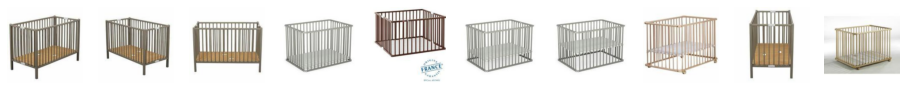

In [ ]:
# images mostly match the reference style, although not perfectly
search_by_style('295981_0.jpg')

In [ ]:
# for all the images in the dataset
all_img = [a for a in images.keys()]

In [ ]:
def search_by_style(reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    return sorted_neighbors[:11]

In [ ]:
# to create a csv of the images which can be used directly in streamlit for visual representation
allImages = [search_by_style(image_name) for image_name in images.keys()]

In [ ]:
# to verify
search_by_style("295981_0.jpg")

[('295981_0.jpg', 0.0),
 ('295981_2.jpg', 0.007101535797119141),
 ('295981_1.jpg', 0.02371114492416382),
 ('1199966_0.jpg', 0.030456602573394775),
 ('2034696_0.jpg', 0.033248305320739746),
 ('1199966_1.jpg', 0.03489786386489868),
 ('1199966_2.jpg', 0.03951370716094971),
 ('709380_0.jpg', 0.06098377704620361),
 ('295981_3.jpg', 0.06164252758026123),
 ('464681_0.jpg', 0.07217037677764893),
 ('2248498_0.jpg', 0.07905232906341553)]

In [ ]:
# to convert into a Panda's Dataframe
allImagesDF = pd.DataFrame(allImages)
print(allImagesDF)

                       0   ...                                     10
0     (118313_0.jpg, 0.0)  ...    (38983_0.jpg, 0.024751126766204834)
1    (1170894_1.jpg, 0.0)  ...  (1211240_0.jpg, 0.036022722721099854)
2    (1180015_1.jpg, 0.0)  ...   (1217793_1.jpg, 0.01501375436782837)
3    (1174936_0.jpg, 0.0)  ...   (451241_0.jpg, 0.021168231964111328)
4    (1158718_0.jpg, 0.0)  ...    (460054_0.jpg, 0.04041421413421631)
..                    ...  ...                                    ...
545   (868312_0.jpg, 0.0)  ...   (2152132_0.jpg, 0.04418838024139404)
546   (877298_1.jpg, 0.0)  ...    (20730_0.jpg, 0.014656662940979004)
547   (877298_0.jpg, 0.0)  ...   (428087_0.jpg, 0.031621694564819336)
548   (850206_2.jpg, 0.0)  ...   (1948024_0.jpg, 0.05624103546142578)
549    (91902_1.jpg, 0.0)  ...  (1836045_2.jpg, 0.050913453102111816)

[550 rows x 11 columns]


In [ ]:
# to return the first element of any list/tuple
def test(sorted_neighbour_tuple):
    return sorted_neighbour_tuple[0]

In [ ]:
# to apply the function
finalfile = allImagesDF.applymap(test)
print(finalfile)

                0              1   ...             9              10
0     118313_0.jpg  1212545_0.jpg  ...   449122_0.jpg    38983_0.jpg
1    1170894_1.jpg  1170894_0.jpg  ...   619948_1.jpg  1211240_0.jpg
2    1180015_1.jpg  1180015_0.jpg  ...  1046349_0.jpg  1217793_1.jpg
3    1174936_0.jpg   970552_0.jpg  ...   261890_1.jpg   451241_0.jpg
4    1158718_0.jpg  1024602_0.jpg  ...  1590116_3.jpg   460054_0.jpg
..             ...            ...  ...            ...            ...
545   868312_0.jpg  1170894_0.jpg  ...  1396752_0.jpg  2152132_0.jpg
546   877298_1.jpg   444101_1.jpg  ...   110899_0.jpg    20730_0.jpg
547   877298_0.jpg   835212_1.jpg  ...   597665_0.jpg   428087_0.jpg
548   850206_2.jpg  1367906_1.jpg  ...  1166708_0.jpg  1948024_0.jpg
549    91902_1.jpg  1342280_0.jpg  ...   562933_0.jpg  1836045_2.jpg

[550 rows x 11 columns]


In [ ]:
# to convert into a csv file
from google.colab import files
finalfile.to_csv('ArtisticSimilarityOutput.csv')

In [ ]:
# to download the csv file
#finalfile.to_csv("ArtisticSimilarityOutput.csv")
files.download('ArtisticSimilarityOutput.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>